In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import csv
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from keras import models, layers, optimizers, regularizers
from sklearn.model_selection import train_test_split, ShuffleSplit, GridSearchCV
from keras import regularizers
%matplotlib inline

Using TensorFlow backend.


In [2]:
raw_df = pd.read_csv('https://grantmlong.com/data/SE_rents2018_train.csv', index_col=0)
raw_test_df = pd.read_csv('https://grantmlong.com/data/SE_rents2018_test1.csv', index_col=0)
raw_test2_df = pd.read_csv('https://grantmlong.com/data/SE_rents2018_test2.csv', index_col=0)
raw_df = raw_df.append(raw_test_df)
raw_df.head(20)
raw_df.columns

Index(['addr_unit', 'building_id', 'bedrooms', 'bathrooms', 'size_sqft',
       'created_at', 'addr_street', 'addr_city', 'addr_zip', 'addr_lat',
       'addr_lon', 'bin', 'bbl', 'floor_count', 'year_built', 'min_to_subway',
       'has_doorman', 'has_elevator', 'has_fireplace', 'has_dishwasher',
       'is_furnished', 'has_gym', 'allows_pets', 'has_washer_dryer',
       'has_garage', 'has_roofdeck', 'has_concierge', 'has_pool', 'has_garden',
       'has_childrens_playroom', 'rent', 'no_fee', 'description',
       'neighborhood', 'borough', 'unit', 'floornumber', 'line'],
      dtype='object')

## Data Explore

In [3]:
raw_df.describe()

,building_id,bedrooms,bathrooms,size_sqft,addr_zip,addr_lat,addr_lon,bin,bbl,floor_count,...,has_washer_dryer,has_garage,has_roofdeck,has_concierge,has_pool,has_garden,has_childrens_playroom,rent,no_fee,floornumber
count,1.400000e+04,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,1.399900e+04,1.400000e+04,14000.000000,...,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,12498.000000
mean,1.542772e+06,1.661643,1.238929,848.388643,10681.801286,40.727746,-73.956776,2.368400e+06,2.285087e+09,10.233350,...,0.268500,0.170714,0.262643,0.208214,0.072357,0.133786,0.089571,3591.997214,0.495786,6.198232
std,4.323673e+06,1.084151,0.550979,513.039489,592.728072,0.053635,0.042994,1.242507e+06,1.200828e+09,12.003629,...,0.443195,0.376273,0.440086,0.406045,0.259088,0.340434,0.285577,2874.099247,0.500000,7.728606
min,7.300000e+01,0.000000,0.000000,0.000000,10001.000000,40.573898,-74.168405,1.000000e+06,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1250.000000,0.000000,0.000000
25%,6.231400e+04,1.000000,1.000000,604.000000,10023.000000,40.693256,-73.986095,1.052178e+06,1.011286e+09,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2250.000000,0.000000,2.000000
50%,2.545810e+05,2.000000,1.000000,800.000000,11103.000000,40.729048,-73.961554,3.018885e+06,3.006580e+09,5.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2900.000000,0.000000,3.000000
75%,8.267980e+05,2.000000,1.000000,1000.000000,11218.000000,40.764801,-73.936080,3.325600e+06,3.050558e+09,12.000000,...,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3900.000000,1.000000,6.000000
max,1.877211e+07,8.000000,20.000000,10000.000000,11694.000000,40.909842,-73.730550,5.158986e+06,5.029930e+09,90.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,50000.000000,1.000000,78.000000


In [4]:
raw_df.shape

(14000, 38)

In [5]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14000 entries, 7236931 to 7463404
Data columns (total 38 columns):
addr_unit                 13890 non-null object
building_id               14000 non-null int64
bedrooms                  14000 non-null int64
bathrooms                 14000 non-null float64
size_sqft                 14000 non-null float64
created_at                14000 non-null object
addr_street               14000 non-null object
addr_city                 14000 non-null object
addr_zip                  14000 non-null int64
addr_lat                  14000 non-null float64
addr_lon                  14000 non-null float64
bin                       13999 non-null float64
bbl                       14000 non-null int64
floor_count               14000 non-null float64
year_built                13530 non-null float64
min_to_subway             13857 non-null float64
has_doorman               14000 non-null int64
has_elevator              14000 non-null int64
has_fireplace    

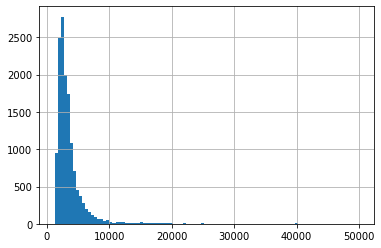

In [6]:
raw_df['rent'].hist(bins=100)

### Seperate all features into continuous, categorical and binary features.

For those none relatived features as below, we have excluded them from the features grouping: 
- addr_unit: no relationship
- building_id: no relationship
- addr_lat: hard to analyze latitude
- addr_lon: hard to analyze longtitude
- bin: no relationship
- bbl: no relationshio
- description: hard to build a NLP model
- unit: no relationship


In [7]:
continuous_features =['bathrooms','bedrooms','size_sqft','floor_count','year_built','min_to_subway','floornumber' ]
caterigal_features =['addr_street','addr_city','addr_zip','neighborhood','borough','line' ]
binary_features = ['has_doorman', 'has_elevator', 'has_fireplace', 'has_dishwasher','is_furnished', 'has_gym', 'allows_pets', 
                   'has_washer_dryer','has_garage', 'has_roofdeck', 'has_concierge', 'has_pool', 'has_garden',
                   'has_childrens_playroom', 'no_fee', ]

## Import external dataset from Internal Revenue Service
 - We will import the 2017 individual income Tax statistic dataset from IRS website(https://www.irs.gov/pub/irs-soi/17zpallagi.csv).
 - We will expend a new feature: **average_income** based on zipcode to our raw dataset 

In [8]:
raw_income_data=pd.read_csv('https://www.irs.gov/pub/irs-soi/17zpallagi.csv', index_col=0)
raw_income_data.columns

Index(['STATE', 'zipcode', 'agi_stub', 'N1', 'mars1', 'MARS2', 'MARS4', 'ELF',
       'CPREP', 'PREP',
       ...
       'N85300', 'A85300', 'N11901', 'A11901', 'N11900', 'A11900', 'N11902',
       'A11902', 'N12000', 'A12000'],
      dtype='object', length=152)

In [9]:
raw_income_data.describe()

,zipcode,agi_stub,N1,mars1,MARS2,MARS4,ELF,CPREP,PREP,DIR_DEP,...,N85300,A85300,N11901,A11901,N11900,A11900,N11902,A11902,N12000,A12000
count,166537.000000,166537.000000,1.665370e+05,1.665370e+05,1.665370e+05,166537.000000,1.665370e+05,166537.000000,1.665370e+05,1.665370e+05,...,166537.000000,1.665370e+05,166537.000000,1.665370e+05,1.665370e+05,1.665370e+05,1.665370e+05,1.665370e+05,166537.000000,1.665370e+05
mean,48870.221668,3.499883,1.797506e+03,8.568076e+02,6.466075e+02,257.395354,1.595375e+03,109.165711,9.565737e+02,1.115313e+03,...,52.247849,2.652260e+02,366.565508,2.075837e+03,1.385102e+03,4.864975e+03,1.349381e+03,3.932834e+03,43.103875,8.790301e+02
std,27140.457939,1.707903,3.682065e+04,2.157115e+04,1.180901e+04,6579.521856,3.234179e+04,2546.536828,1.996698e+04,2.347348e+04,...,2663.659358,1.535593e+04,6891.242958,6.608186e+04,2.947749e+04,1.012458e+05,2.909491e+04,7.693938e+04,947.324343,4.399491e+04
min,0.000000,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,...,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
25%,27030.000000,2.000000,7.000000e+01,0.000000e+00,4.000000e+01,0.000000,6.000000e+01,0.000000,4.000000e+01,4.000000e+01,...,0.000000,0.000000e+00,20.000000,2.100000e+01,5.000000e+01,1.580000e+02,4.000000e+01,1.410000e+02,0.000000,0.000000e+00
50%,48876.000000,3.000000,2.500000e+02,7.000000e+01,1.100000e+02,20.000000,2.200000e+02,0.000000,1.500000e+02,1.400000e+02,...,0.000000,0.000000e+00,60.000000,1.550000e+02,1.800000e+02,6.220000e+02,1.700000e+02,5.480000e+02,0.000000,0.000000e+00
75%,70601.000000,5.000000,1.020000e+03,3.400000e+02,3.800000e+02,90.000000,9.100000e+02,60.000000,5.600000e+02,5.900000e+02,...,0.000000,0.000000e+00,220.000000,6.870000e+02,7.400000e+02,2.484000e+03,7.100000e+02,2.207000e+03,30.000000,6.400000e+01
max,99999.000000,6.000000,5.824360e+06,4.130490e+06,1.757700e+06,982390.000000,4.980210e+06,475240.000000,3.387570e+06,3.233490e+06,...,763140.000000,4.031847e+06,890950.000000,1.750126e+07,4.598480e+06,1.667374e+07,4.561540e+06,9.443931e+06,186110.000000,1.056186e+07


### Income Dataset Description 
This dataset comes from the IRS website's 2017 ZIP Code Data (SOI) about Individual Income Tax Statistics.
According to the documentation's overview,the Statistics of Income (SOI) Division’s ZIP code data is tabulated using individual income tax returns (Forms 1040) filed with the Internal Revenue Service (IRS) during the 12-month period, January 1, 2018 to December 31, 2018.
The original dataset contains many income and Tax Items, we only keep the ones that are relevant: 
- STATEFIPS:The State Federal Information Processing System (FIPS) code
- STATE: The State associated with the ZIP code
- ZIPCODE: 5-digit Zip code
- agi_stub: Size of adjusted gross income
- N1: Total number of returns
- A02650: Number of returns with total income

Our goal is to find the average income of each zipcode.

### Clean the raw income data and rename feature

In [10]:
raw_income_data = raw_income_data.loc[raw_income_data['STATE']=='NY']
raw_income_data.rename(columns = {'N1':'total_returns', 'A02650':'total_income'}, inplace = True) 
raw_income_data = raw_income_data[['STATE','zipcode','agi_stub','total_returns', 'total_income']]
raw_income_data = raw_income_data.loc[raw_income_data['zipcode']<99999]
raw_income_data = raw_income_data.loc[raw_income_data['zipcode']>0]


### Function to calculate the average income by zip code
Each zip code has 6 different sizes of adjusted gross income which means we have 6 different number of total returns and total income for one zip code.
By using the np.where and sum function, we can obtain the sum of income and sum of returns for each zip code. The income of the original dataset was in thousands of dollar so we need to multiply the sum of income by 1000 and then find the average. Since some zip code was not in the original set, we ingore those average that is NaN and only write the meaningful averages to csv file for future use.

- Calculate average income 
- Export to ny_income_2017.csv for storage
- For next time, no need to import the raw_income_dataset again

In [11]:
average_income = pd.DataFrame({'addr_zip':[],'zip_average_income':[]})

def calculate_avg_income():
    global average_income
    for zipcode in range(10001, 14906):
        current_sum=np.where(raw_income_data['zipcode']==zipcode, raw_income_data['total_income'],0).sum()
        current_returns=np.where(raw_income_data['zipcode']==zipcode, raw_income_data['total_returns'],0).sum() 
        if(current_returns <=0 or current_sum<=0):
            continue
        avg_income=(current_sum*1000)/current_returns
        new_row={'addr_zip':zipcode,'zip_average_income':avg_income}
        average_income=average_income.append(new_row,ignore_index=True)           
calculate_avg_income()
average_income.head(5)

,addr_zip,zip_average_income
0,10001.0,183859.908735
1,10002.0,59669.401750
2,10003.0,306277.962003
3,10004.0,385265.306122
4,10005.0,391201.520270


 - We realize that the income dataset is missing all income data between zipcode 11239 - 11354, we will take an averge of zipcode income for 11239 and 11354 to replace any zipcode income in between 
 - In our training and testing dataset, only the zipcode income 11249 is missing

In [12]:
print(list(set(raw_df['addr_zip']) - set(average_income['addr_zip'])))
print(list(set(raw_test_df['addr_zip']) - set(average_income['addr_zip'])))

[11249]
[11249]


**Insert a new row for zipcode income 11249 into the average_income dataframe**

In [13]:
avg_income = (average_income.loc[(average_income['addr_zip']==11239)].iloc[0]['zip_average_income'] +
             average_income.loc[(average_income['addr_zip']==11354)].iloc[0]['zip_average_income'])/2
new_row = {'addr_zip':11249,'zip_average_income':avg_income}
average_income=average_income.append(new_row,ignore_index=True)  

### Merge the raw train  dataset with the income dataset by addr_zip

In [14]:
raw_test2_df=raw_test_df.reset_index().merge(average_income, how="left",on='addr_zip').set_index('rental_id')
raw_df=raw_df.reset_index().merge(average_income, how="left",on='addr_zip').set_index('rental_id')

### Find zip_average_income and rent cooleration

In [15]:
continuous_features.append('zip_average_income')

In [16]:
continuous_df = raw_df[['zip_average_income','rent']]
continuous_df.corr()['rent'][:-1]


zip_average_income    0.393228
Name: rent, dtype: float64

**The correlation between zip_average_income and rent is 0.393228, it is good enough to consider as a important feature that might impact the rent**

# Data Cleaning


### Handling missing data
In order to handle missing data in this dataset, we frist find and count all the null values.

In [17]:
raw_df.isna().sum()

addr_unit                  110
building_id                  0
bedrooms                     0
bathrooms                    0
size_sqft                    0
created_at                   0
addr_street                  0
addr_city                    0
addr_zip                     0
addr_lat                     0
addr_lon                     0
bin                          1
bbl                          0
floor_count                  0
year_built                 470
min_to_subway              143
has_doorman                  0
has_elevator                 0
has_fireplace                0
has_dishwasher               0
is_furnished                 0
has_gym                      0
allows_pets                  0
has_washer_dryer             0
has_garage                   0
has_roofdeck                 0
has_concierge                0
has_pool                     0
has_garden                   0
has_childrens_playroom       0
rent                         0
no_fee                       0
descript

As we can see from the result,there are missing data appearing on: 
- addr_unit
- bin 
- year_built 
- min_to_subway 
- description 
- neighborhood 
- unit 
- floornumber 
- line 

Base on our data exploration, we can see that in this case, all features beside year_built,min_to_subway,neighborhood,and floornumber has not much impact to our final result, thus we don't need to worry about them.

Then, we will be dropping the rows which we don't have values for year_built, min_to_subway, neighborhood, and floornumber.

In [18]:
# We will call the new df md_df
# md_df = raw_df.loc[
#     raw_df.year_built.notnull() &
#     raw_df.min_to_subway.notnull() & 
#     raw_df.neighborhood.notnull() & 
#     raw_df.floornumber.notnull()
# ]

# Reminder:
# use mode to replace NAN value, compare both method when creating models
md_df = raw_df.loc[
    raw_df.year_built.notnull() &
    raw_df.min_to_subway.notnull() & 
    raw_df.neighborhood.notnull() 
]

md_df['floornumber'].fillna(md_df['floornumber'].mode()[0], inplace=True)
raw_test2_df['floornumber'].fillna(raw_test2_df['floornumber'].mode()[0], inplace=True)



print("original shape of dataset:",raw_df.shape)
print("shape of dataset after handling missing data:",md_df.shape)

original shape of dataset: (14000, 39)
shape of dataset after handling missing data: (13394, 39)


D:\Anaconda3\lib\site-packages\pandas\core\generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


## Remove outliers

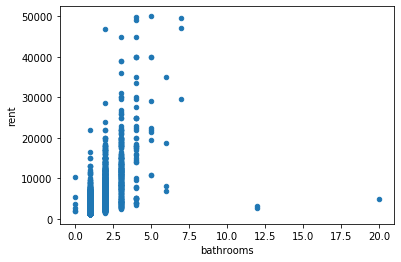

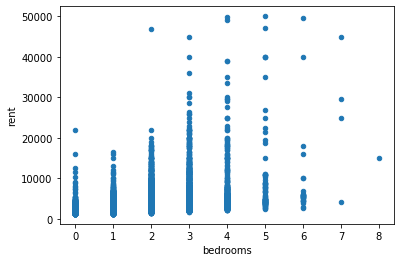

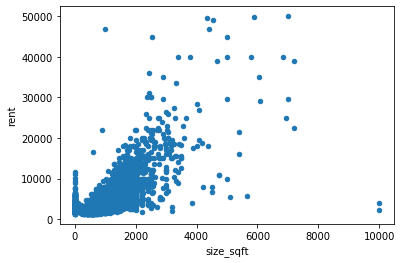

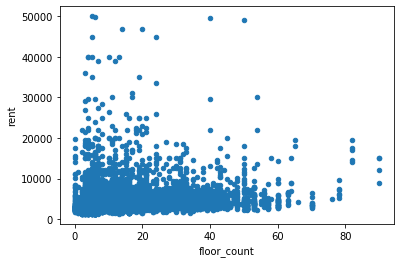

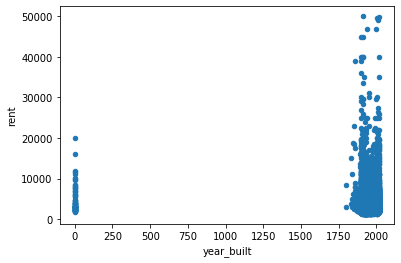

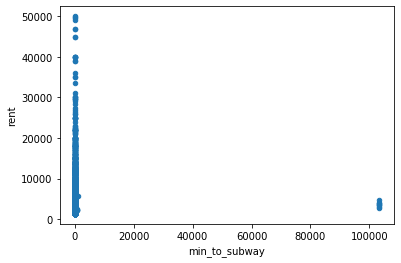

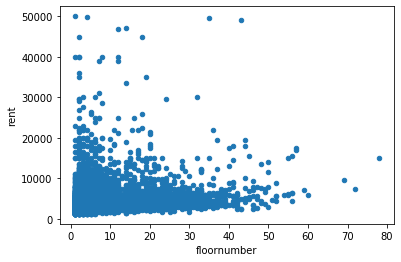

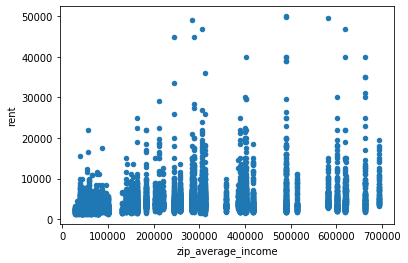

In [19]:
for feature in continuous_features:
    md_df.plot.scatter(feature, 'rent')

In [20]:
md_df[md_df['rent']>40000].count()

addr_unit                 8
building_id               8
bedrooms                  8
bathrooms                 8
size_sqft                 8
created_at                8
addr_street               8
addr_city                 8
addr_zip                  8
addr_lat                  8
addr_lon                  8
bin                       8
bbl                       8
floor_count               8
year_built                8
min_to_subway             8
has_doorman               8
has_elevator              8
has_fireplace             8
has_dishwasher            8
is_furnished              8
has_gym                   8
allows_pets               8
has_washer_dryer          8
has_garage                8
has_roofdeck              8
has_concierge             8
has_pool                  8
has_garden                8
has_childrens_playroom    8
rent                      8
no_fee                    8
description               8
neighborhood              8
borough                   8
unit                

**drop size_sqrt = 0 for now, since there are 713 rows, might replace with mode when creating models**

In [21]:
def remove_outliers(md_df, feature, low_value, high_value):
    print(feature, ': ', md_df.shape)
    md_df = md_df[md_df[feature]>low_value]
    md_df = md_df[md_df[feature]<=high_value]
    md_df.reset_index(drop=True,inplace=True)
    print(feature, ': ', md_df.shape)
    return md_df

md_df = remove_outliers(md_df, 'rent', 0, 40000)
md_df = remove_outliers(md_df, 'bathrooms', 0, 12)
md_df = remove_outliers(md_df, 'size_sqft', 0, 10000)
md_df = remove_outliers(md_df, 'year_built', 1700, 2019)
md_df = remove_outliers(md_df, 'min_to_subway', 0, 60)
md_df = remove_outliers(md_df, 'floornumber', 0, 60)

md_df['year_built'] = 2019 - md_df['year_built'].astype(int)

rent :  (13394, 39)
rent :  (13386, 39)
bathrooms :  (13386, 39)
bathrooms :  (13379, 39)
size_sqft :  (13379, 39)
size_sqft :  (12399, 39)
year_built :  (12399, 39)
year_built :  (12328, 39)
min_to_subway :  (12328, 39)
min_to_subway :  (12316, 39)
floornumber :  (12316, 39)
floornumber :  (12313, 39)


### Encode categorical feature and drop useless features

In [22]:
boroughs = np.array(md_df['borough'].unique())

for borough in boroughs:
    md_df[borough] = md_df['borough'].apply(lambda x : int(x == borough))
    raw_test2_df[borough] = raw_test2_df['borough'].apply(lambda x : int(x == borough))

features_notNeed = ['addr_unit', 'building_id', 'created_at', 'addr_street', 'addr_city', 'addr_zip', 'bin', 'bbl', 'description', \
                    'neighborhood', 'unit', 'borough', 'line']

md_df = md_df.drop(features_notNeed, axis=1)

### Use pair coorelation for continuous features

In [23]:
continuous_df = md_df[continuous_features+['rent']]
continuous_df.corr()['rent'][:-1]

bathrooms             0.638473
bedrooms              0.348422
size_sqft             0.699390
floor_count           0.264480
year_built           -0.109256
min_to_subway        -0.077426
floornumber           0.252563
zip_average_income    0.421969
Name: rent, dtype: float64

### Check coorelation for binary features

In [24]:
md_df[binary_features+['rent']].corr()['rent'][:-1]
coor_results= []

for feature in binary_features:
  df = raw_df.groupby([feature]).aggregate(['mean'])['rent']
  df[feature]= df.index
  coor_results.append(df.corr().iloc[0][1])
coor_df = pd.DataFrame({'Coorelation': coor_results,'Feature':binary_features})
coor_df


,Coorelation,Feature
0,1.0,has_doorman
1,1.0,has_elevator
2,1.0,has_fireplace
3,1.0,has_dishwasher
4,1.0,is_furnished
5,1.0,has_gym
6,1.0,allows_pets
7,1.0,has_washer_dryer
8,1.0,has_garage
9,1.0,has_roofdeck


As we can see in the correlation table, all binrary features highly affected the rents. When we build the models, we should include all binary features.

# Build Models
We will be using cross validation to evaluate the performances of our all modles,and then deciding which should be the most suitable one, thus we will first create a function called get_cv_results to obtain the cv_performance.

In [25]:
md_df = shuffle(md_df).reset_index(drop=True)


In [26]:
features = list(md_df.columns)
features.remove('rent')
k_fold = KFold(n_splits=10)

In [27]:
def get_cv_results(regressor):
    
    results = []
    for train, test in k_fold.split(md_df):
        regressor.fit(md_df.loc[train, features], md_df.loc[train, 'rent'])
        y_predicted = regressor.predict(md_df.loc[test, features])
        accuracy = mean_squared_error(md_df.loc[test, 'rent'], y_predicted)**0.5
        results.append(accuracy)

    return np.mean(results), np.std(results)

### Radnom Forest Model

In [28]:
rforest = RandomForestRegressor(
    random_state=11, 
    max_depth=10,
    n_estimators=200
)


In [30]:
get_cv_results(rforest)

(1006.0684117666148, 140.2124513591036)

In [31]:
rforest.fit(md_df[features], md_df['rent'])  
for feature,score in sorted(zip(features,rforest.feature_importances_), key=lambda x:x[1], reverse=True):
    print(feature, ' ', score)

size_sqft   0.5486262614965186
zip_average_income   0.20056785135135713
bathrooms   0.11025891766648362
addr_lon   0.024233526807983626
addr_lat   0.02020014535481492
year_built   0.016131927096882694
bedrooms   0.015318409149003578
floor_count   0.010769874039296686
floornumber   0.010228082804667343
min_to_subway   0.009365878135182283
has_roofdeck   0.0058086795801907615
has_gym   0.005744457673909175
no_fee   0.0028412560758757496
has_washer_dryer   0.0028382530286903186
has_dishwasher   0.0025483757022389994
is_furnished   0.0024664414032943213
has_elevator   0.0019516697018954158
has_concierge   0.0016324742169201319
has_garden   0.001440915435841744
has_doorman   0.001367857678235838
allows_pets   0.0012844064895364603
has_pool   0.0011756169683861484
Manhattan   0.0008991418787541671
has_fireplace   0.0008014650104304003
has_childrens_playroom   0.000739097718198675
has_garage   0.0005288517018815939
Brooklyn   0.0002097396258042829
Queens   1.5096061143258589e-05
Bronx   4.473

### Multiple Regression

In [32]:
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

In [33]:
mul_reg_features = features[:]
x = md_df[features] 
y = md_df['rent']
est = sm.OLS(y, x).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   rent   R-squared:                       0.719
Model:                            OLS   Adj. R-squared:                  0.718
Method:                 Least Squares   F-statistic:                     1082.
Date:                Mon, 18 Nov 2019   Prob (F-statistic):               0.00
Time:                        14:45:08   Log-Likelihood:            -1.0707e+05
No. Observations:               12313   AIC:                         2.142e+05
Df Residuals:                   12283   BIC:                         2.144e+05
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
bedrooms                  26.8220     17.608      1.523      0.128      -7.693      61.337
bathrooms               1061.4341     34.801     30.500      0.000     993.218    1129.650
size_sqft                  3.1486      0.044     71.596      0.000       3.062       3.235
addr_lat                2402.5441    430.784      5.577      0.000    1558.140    3246.948
addr_lon               -6103.0457    509.426    -11.980      0.000   -7101.601   -5104.490
floor_count              -14.9775      2.372     -6.315      0.000     -19.626     -10.329
year_built                 0.1607      0.461      0.348      0.728      -0.744       1.065
min_to_subway            -20.1435      3.717     -5.420      0.000     -27.429     -12.858
has_doorman              125.8559     49.502      2.542      0.011      28.824     222.888
has_elevator             301.6744     40.446      7.459      0.000     222.394     380.954
has_fireplace            400.2070     70.539      5.674      0.000     261.939     538.475
has_dishwasher          -158.7147     30.347     -5.230      0.000    -218.199     -99.230
is_furnished             583.7895     75.434      7.739      0.000     435.928     731.651
has_gym                  366.2758     49.919      7.337      0.000     268.426     464.126
allows_pets              141.1246     29.249      4.825      0.000      83.792     198.458
has_washer_dryer         299.2661     33.863      8.838      0.000     232.890     365.642
has_garage              -120.3581     42.023     -2.864      0.004    -202.730     -37.987
has_roofdeck             171.7414     37.262      4.609      0.000      98.702     244.781
has_concierge            199.8013     50.571      3.951      0.000     100.674     298.929
has_pool                 114.5246     60.088      1.906      0.057      -3.257     232.306
has_garden               -15.2094     41.199     -0.369      0.712     -95.966      65.547
has_childrens_playroom   109.0733     55.759      1.956      0.050      -0.223     218.370
no_fee                  -139.1202     29.908     -4.652      0.000    -197.744     -80.497
floornumber               25.3497      2.964      8.553      0.000      19.540      31.159
zip_average_income         0.0028      0.000     22.897      0.000       0.003       0.003
Brooklyn               -5.509e+05   4.68e+04    -11.783      0.000   -6.43e+05   -4.59e+05
Manhattan              -5.504e+05   4.68e+04    -11.766      0.000   -6.42e+05   -4.59e+05
Queens                 -5.508e+05   4.67e+04    -11.784      0.000   -6.42e+05   -4.59e+05
Bronx                  -5.516e+05   4.68e+04    -11.792      0.000   -6.43e+05    -4.6e+05
Staten Island          -5.532e+05   4.68e+04    -11.819      0.000   -6.45e+05   -4.61e+05
==============================================================================
O

In [34]:
mul_reg_features.remove('has_garden')
mul_reg_features.remove('year_built')
mul_reg_features.remove('bedrooms')

In [35]:
mul_reg = LinearRegression().fit(md_df[mul_reg_features], md_df['rent'])
get_cv_results(mul_reg)

(1454.94383582609, 126.85144357399963)

## Gradient Boosting Regression
For the gradient boosting regressor we will first set up the hyperparameter max_depth=5 to avoid overfitting, will adjust more hyperparameter as we move on to improve the model


In [36]:
gbrdemo = GradientBoostingRegressor(
    max_depth=5,
    n_estimators=100
)

get_cv_results(gbrdemo)

(960.984006759841, 133.0257933747557)

### Tuning Hyperparameters
Now let's use GridSearchCV form sci-kit learn model_selection to tune the hyperparameters, and find the most suitable one for our Gradient Boosting Regression model.

In [37]:
# Tuning the hyperparameters based on a cross-validation subset (cv)
# cited link: link: https://shankarmsy.github.io/stories/gbrt-sklearn.html

def GradientBooster():
    
    param_grid={'n_estimators':[100],
            'learning_rate': [0.1, 0.05, 0.01],
            'max_depth':[4, 5, 6],
            'min_samples_leaf':[3, 5, 9],
           }
    
    # choose cross validation generator and use ShuffleSplit which randomly shuffles and selects Train and CV sets
    cv = ShuffleSplit(n_splits=5, test_size=.25, random_state=0)
    
    classifier = GridSearchCV(estimator = GradientBoostingRegressor(), param_grid=param_grid, n_jobs=4, cv=cv)
    
    classifier.fit(md_df[features], md_df['rent'])  
    return classifier.best_params_

In [47]:
# Since this function takes too long to run, it will waste a lot of time during development,
# so we will just record the result for further usage. -----Runmin 11/18/19
"""
best_est=GradientBooster()

print("Best Estimator Parameters:")
print("n_estimators: ",best_est['n_estimators'])
print("max_depth: ", best_est['max_depth'])
print("Learning Rate: ", best_est['learning_rate'])
print("min_samples_leaf: ", best_est['min_samples_leaf'])
"""
print("Since this function takes too long to run, it will waste a lot of time during development,\
      \nso we will just record the result for further usage:")
print("\nBest Estimator Parameters:")
print("n_estimators: ",100)
print("max_depth: ", 6)
print("Learning Rate: ", 0.1)
print("min_samples_leaf: ", 3)

Since this function takes too long to run, it will waste a lot of time during development,      
so we will just record the result for further usage:

Best Estimator Parameters:
n_estimators:  100
max_depth:  6
Learning Rate:  0.1
min_samples_leaf:  3


As we can see from the result above, we have found the suitable hyperparameters for our model, thus we can use them to check if a better result will be obtained.


In [42]:
bettergbr1 = GradientBoostingRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    min_samples_leaf=3
)

get_cv_results(bettergbr1)

(949.5810682059418, 146.15814613574975)

We do see some improvements on the mean squared error after we adjusted the hyperparameter a bit

### Neural Network

In [49]:
scaler = StandardScaler()
X = scaler.fit_transform(md_df[features])
Y = md_df['rent'].values.reshape(-1,1)

train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.2, random_state=42)

In [56]:
net = models.Sequential()
net.add(layers.Dense(64, input_dim=train_x.shape[1], kernel_regularizer=regularizers.l1(0.1), activation='relu'))
net.add(layers.Dropout(0.1))

net.add(layers.Dense(64, kernel_regularizer=regularizers.l1(0.1), activation='relu'))
net.add(layers.Dropout(0.1))

net.add(layers.Dense(128, kernel_regularizer=regularizers.l1(0.1), activation='relu'))
net.add(layers.Dropout(0.1))

net.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.1), activation='relu'))
net.add(layers.Dropout(0.1))

net.add(layers.Dense(1, activation='linear'))

net.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

In [58]:
net.fit(train_x, train_y, epochs=150, batch_size=64, validation_split = 0.1)

Train on 8865 samples, validate on 985 samples
Epoch 1/150
8865/8865 [==============================] - 2s 235us/step - loss: 1513773.4409 - mean_squared_error: 1513393.3607 - val_loss: 3901693.2878 - val_mean_squared_error: 3901314.6614
Epoch 2/150
8865/8865 [==============================] - 2s 215us/step - loss: 1507564.0136 - mean_squared_error: 1507184.7077 - val_loss: 4166226.1558 - val_mean_squared_error: 4165846.8878
Epoch 3/150
8865/8865 [==============================] - 2s 216us/step - loss: 1505047.9446 - mean_squared_error: 1504670.6170 - val_loss: 4007223.7360 - val_mean_squared_error: 4006847.1310
Epoch 4/150
8865/8865 [==============================] - 2s 204us/step - loss: 1536070.5744 - mean_squared_error: 1535693.9626 - val_loss: 4242177.2107 - val_mean_squared_error: 4241799.8635
Epoch 5/150
8865/8865 [==============================] - 2s 197us/step - loss: 1514593.6765 - mean_squared_error: 1514218.0863 - val_loss: 4393121.9462 - val_mean_squared_error: 4392744.475

D:\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.203503). Check your callbacks.
  % delta_t_median)
D:\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.102251). Check your callbacks.
  % delta_t_median)


8865/8865 [==============================] - 2s 208us/step - loss: 896740.8439 - mean_squared_error: 896283.8829 - val_loss: 3085394.3985 - val_mean_squared_error: 3084934.6891
Epoch 63/150
8865/8865 [==============================] - 2s 189us/step - loss: 914088.6328 - mean_squared_error: 913628.9500 - val_loss: 2649297.2594 - val_mean_squared_error: 2648838.1183
Epoch 64/150
8865/8865 [==============================] - 2s 225us/step - loss: 918865.3685 - mean_squared_error: 918406.2557 - val_loss: 2835598.9865 - val_mean_squared_error: 2835135.9581
Epoch 65/150
8865/8865 [==============================] - 2s 204us/step - loss: 922870.6143 - mean_squared_error: 922408.6590 - val_loss: 2680537.5335 - val_mean_squared_error: 2680075.0152
Epoch 66/150
8865/8865 [==============================] - 1s 159us/step - loss: 945324.2398 - mean_squared_error: 944859.8071 - val_loss: 3198837.1137 - val_mean_squared_error: 3198370.4449
Epoch 67/150
8865/8865 [==============================] - 2s 23

Epoch 148/150
8865/8865 [==============================] - 2s 206us/step - loss: 720102.1906 - mean_squared_error: 719563.8448 - val_loss: 2234481.4230 - val_mean_squared_error: 2233940.9585
Epoch 149/150
8865/8865 [==============================] - 2s 267us/step - loss: 781342.9540 - mean_squared_error: 780802.7222 - val_loss: 3630313.3485 - val_mean_squared_error: 3629766.4581
Epoch 150/150
8865/8865 [==============================] - 2s 178us/step - loss: 708864.2165 - mean_squared_error: 708324.4256 - val_loss: 2363182.2987 - val_mean_squared_error: 2362642.1169


In [59]:
mean_squared_error(test_y, net.predict(test_x))

1019262.9646723561

**Although the DL Neural Network seems to provide a better result on mean squared errors but it is really unstable** 

we have ran few test run on it, and each time it gives different results range from 853411.6171418771 to around 1,300,000.
Therefore, we might still choose Gradient Boosting Regression as the most suitable model, since it provides a overall better result.